# Simulation Manager

In this example notebook, we will use the simulation manager tool available in NeuralPlayground. The purpose of this tool is the following:
- Run multiple instantiations of model and environments, saved in an organized manner, logging trained agents, error logs, etc…
- Keep track of the status of each run.
- Access to a default set of simulations that can be easily modified or augmented with new models and environments. 
- The results from the simulations can be used with the comparison tool, for quick visualization of results.


## SingleSim
We will start by describing the class that manages single agent-arena pairs, called SingleSim. Objects from this class take the simulation parameters, and it can run the simulation and save the results on the path given by the user, taking care of saving trained agents, simulation parameters, run status, and error logs. 

First, let's import SR model, a Simple2D arena, and a training loop function that describes the interaction of the agent with the arena.

In [1]:
from neuralplayground.agents import Stachenfeld2018
from neuralplayground.arenas import Simple2D
from neuralplayground.backend import episode_based_training_loop

from neuralplayground.backend import SingleSim

Now, let's define the parameters of each element we imported. The SingleSim objects takes the following arguments

In [2]:
simulation_id = "SR_custom_sim"
agent_class = Stachenfeld2018
env_class = Simple2D
training_loop = episode_based_training_loop

# Specific parameters for agents, environments and training loop can be written as dictionaries
agent_params = {"discount": 0.99,
                "threshold": 1e-6,
                "lr_td": 1e-2,
                "state_density": 1,
                "room_width": 12,
                "room_depth": 12,
                "twoD": True}

env_params = {"arena_x_limits": [-6, 6],
              "arena_y_limits": [-6, 6],
              "env_name": "env_example",
              "time_step_size": 0.2,
              "agent_step_size": 1}

# Short training just for demonstration
training_loop_params = {"t_episode": 100, "n_episode": 10}

We initialize the SingleSim object

In [3]:
sim = SingleSim(simulation_id = simulation_id,
                agent_class = agent_class,
                agent_params = agent_params,
                env_class = env_class,
                env_params = env_params,
                training_loop = training_loop,
                training_loop_params = training_loop_params)

In [4]:
print(sim)

Simulation: SR_custom_sim
Agent: <class 'neuralplayground.agents.stachenfeld_2018.Stachenfeld2018'>
Agent params: {'discount': 0.99, 'threshold': 1e-06, 'lr_td': 0.01, 'state_density': 1, 'room_width': 12, 'room_depth': 12, 'twoD': True}
Environment: <class 'neuralplayground.arenas.simple2d.Simple2D'>
Environment params: {'arena_x_limits': [-6, 6], 'arena_y_limits': [-6, 6], 'env_name': 'env_example', 'time_step_size': 0.2, 'agent_step_size': 1}
Training loop: <function episode_based_training_loop at 0x7ff15969e520>
Training loop params: {'t_episode': 100, 'n_episode': 10}



In [5]:
sim.run_sim()

When running a simulation, the results will be saved in ```results_sim``` in the working directory by default. Every simulation result folder should contain:
agent: Trained agent object.
arena: Arena object used to train the agent.
training_hist.dict: A dictionary with variables returned by the train loop on each iteration.
param.dict: Simulation parameters.
run.log: Any outputs printed by agents, environments, or training loop during training.
error.log: Same as run.log but with errors.
state.log: Used with keywords to keep track of the running status of the simulation.

So far, when the user runs the simulation calling ```run_sim```, the run will stop if there is an error in the code and will be printed directly on the default output. The logs were made for the simulation manager described later.

You can load the results of the specific run using ```load_results``` method, getting the trained agent, environment and training history. These objects have all the methods and attributes from the original simulation at your disposal.


In [6]:
trained_agent, env, training_hist = sim.load_results()

In [7]:
sim.show_logs()

/home/rodrigo/anaconda3/envs/NPG-dev/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float64
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")



<Axes: title={'center': 'position'}, xlabel='width', ylabel='depth'>

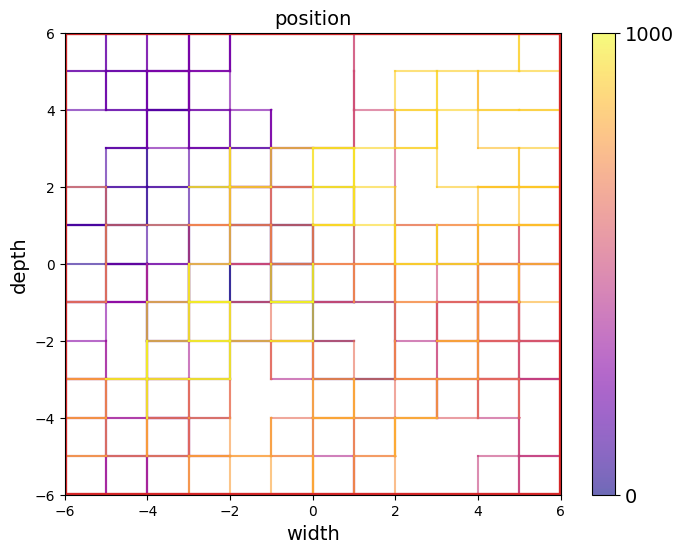

In [8]:
env.plot_trajectory()

It is also possible to load the parameters of an existing simulation and run it again with the same or different set of parameters. For example, we can create an empty SingleSim object, load the parameters of the existing one, change the parameters, and run the simulation.

In [9]:
sim2 = SingleSim()

In [10]:
sim2.load_params("results_sim")

In [11]:
print(sim2)

Simulation: SR_custom_sim
Agent: <class 'neuralplayground.agents.stachenfeld_2018.Stachenfeld2018'>
Agent params: {'discount': 0.99, 'threshold': 1e-06, 'lr_td': 0.01, 'state_density': 1, 'room_width': 12, 'room_depth': 12, 'twoD': True}
Environment: <class 'neuralplayground.arenas.simple2d.Simple2D'>
Environment params: {'arena_x_limits': [-6, 6], 'arena_y_limits': [-6, 6], 'env_name': 'env_example', 'time_step_size': 0.2, 'agent_step_size': 1}
Training loop: <function episode_based_training_loop at 0x7ff15969e520>
Training loop params: {'t_episode': 100, 'n_episode': 10}



In [12]:
new_params = sim2.agent_params  # Here we take the agent parameters
new_params["lr_td"] = 0.001   # Change the learning rate
sim2.agent_params = new_params  # Set the parameters with the new learning rate
print(sim2)
sim2.run_sim("small_lr_sim")  # Run with all parameters equal except for the learning rate

Simulation: SR_custom_sim
Agent: <class 'neuralplayground.agents.stachenfeld_2018.Stachenfeld2018'>
Agent params: {'discount': 0.99, 'threshold': 1e-06, 'lr_td': 0.001, 'state_density': 1, 'room_width': 12, 'room_depth': 12, 'twoD': True}
Environment: <class 'neuralplayground.arenas.simple2d.Simple2D'>
Environment params: {'arena_x_limits': [-6, 6], 'arena_y_limits': [-6, 6], 'env_name': 'env_example', 'time_step_size': 0.2, 'agent_step_size': 1}
Training loop: <function episode_based_training_loop at 0x7ff15969e520>
Training loop params: {'t_episode': 100, 'n_episode': 10}



There are some default simulations that can be found in the [backend code](aslkdmaslkd), where simulation parameters are already configured and initialized as a SingleSim object, for example, Weber2018 running on a squared room 

In [13]:
from neuralplayground.backend.default_simulation import weber_in_2d

In [14]:
print(weber_in_2d)

Simulation: weber_2018_in_simple2D
Agent: <class 'neuralplayground.agents.weber_2018.Weber2018'>
Agent params: {'exc_eta': 0.0002, 'inh_eta': 0.0008, 'model_name': 'weber_2018', 'sigma_exc': array([0.05, 0.05]), 'sigma_inh': array([0.1, 0.1]), 'Ne': 4900, 'Ni': 1225, 'Nef': 1, 'Nif': 1, 'alpha_i': 1, 'alpha_e': 1, 'we_init': 1.0, 'wi_init': 1.5, 'agent_step_size': 0.1, 'resolution': 100, 'ro': 1, 'room_width': 20.0, 'room_depth': 20.0, 'disable_tqdm': True}
Environment: <class 'neuralplayground.arenas.simple2d.Simple2D'>
Environment params: {'arena_x_limits': array([-10,  10]), 'arena_y_limits': array([-10,  10]), 'env_name': 'env_example', 'time_step_size': 1, 'agent_step_size': 0.5}
Training loop: <function default_training_loop at 0x7ff15969e480>
Training loop params: {'n_steps': 1000}



With time, we hope to increase the repository of simulations that can reproduce the results of models from different papers, compare against different experimental findings, and also improve code structure. This allows the user to have access to run models out of the box in a reproducible manner, as well as include their own model to the pipeline to easily run their code (agents, environments, and experiments) against any other class in the repo. At the moment, the configured simulations are just for demonstration, then just running for a few iterations.

## Simulation Manager

Now, let’s introduce the ```SimulationManager``` tool, which takes a list of SingleSim objects and manages each simulation and the state of each run. Let’s take our custom simulation, along with some of the default ones available in the [backend code](aslkdmaslkd)

In [15]:
from neuralplayground.backend.default_simulation import stachenfeld_in_2d
from neuralplayground.backend import SimulationManager

Let's break one of the simulation just to show how the logging system works

In [16]:
aux_params = stachenfeld_in_2d.agent_params
aux_params["lr_td"] = "weird_learning_rate"  # We are breaking the process on purpose
stachenfeld_in_2d.agent_params = aux_params
my_sims = [sim, weber_in_2d, stachenfeld_in_2d]

The simulation manager takes 4 arguments:
- ```simulation_list```: List filled with SingleSim objects
- ```runs_per_sim```: Integer indicating how many runs per simulation you want to get
- ```manager_id```: String that identifies the simulation object, used to save all the results
- ```verbose```: If true, print more details about the object
- ```existing_simulation```: If you want to re-load the results from an existing simulation, you can give the path to the stored simulation as an argument (it will ignore the rest of the arguments in this case)

Then, we can initialize a simulation manager as follows:


In [17]:
my_manager = SimulationManager(simulation_list = my_sims,
                               runs_per_sim = 5,
                               manager_id = "example_simulation",
                               verbose = True)

SimulationManager "example_simulation" 
with ['SR_custom_sim', 'weber_2018_in_simple2D', 'stachenfeld_2018_in_simple2D'] simulations 
and 5 runs per simulation


To run every simulation, first, we create the paths where the results will be saved, then we run everything following the parameters of each simulation. One important thing to notice is that in the scenario that there is an error during any of the runs, the simulation manager will log the errors in the corresponding paths and continue with the rest of the runs.

In [18]:
my_manager.generate_sim_paths()  # Here is the tree with simulations per model, stored by run id and date

example_simulation
  example_simulation/SR_custom_sim
    example_simulation/SR_custom_sim/run_0_24-07-2023_22-46-49-234
    example_simulation/SR_custom_sim/run_1_24-07-2023_22-46-49-234
    example_simulation/SR_custom_sim/run_2_24-07-2023_22-46-49-234
    example_simulation/SR_custom_sim/run_3_24-07-2023_22-46-49-234
    example_simulation/SR_custom_sim/run_4_24-07-2023_22-46-49-234
  example_simulation/weber_2018_in_simple2D
    example_simulation/weber_2018_in_simple2D/run_0_24-07-2023_22-46-49-234
    example_simulation/weber_2018_in_simple2D/run_1_24-07-2023_22-46-49-235
    example_simulation/weber_2018_in_simple2D/run_2_24-07-2023_22-46-49-235
    example_simulation/weber_2018_in_simple2D/run_3_24-07-2023_22-46-49-235
    example_simulation/weber_2018_in_simple2D/run_4_24-07-2023_22-46-49-235
  example_simulation/stachenfeld_2018_in_simple2D
    example_simulation/stachenfeld_2018_in_simple2D/run_0_24-07-2023_22-46-49-235
    example_simulation/stachenfeld_2018_in_simple2D/run

In [19]:
my_manager.run_all()

Running simulation at path:
example_simulation/SR_custom_sim/run_0_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/SR_custom_sim/run_1_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/SR_custom_sim/run_2_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/SR_custom_sim/run_3_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/SR_custom_sim/run_4_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/weber_2018_in_simple2D/run_0_24-07-2023_22-46-49-234
Running simulation at path:
example_simulation/weber_2018_in_simple2D/run_1_24-07-2023_22-46-49-235
Running simulation at path:
example_simulation/weber_2018_in_simple2D/run_2_24-07-2023_22-46-49-235
Running simulation at path:
example_simulation/weber_2018_in_simple2D/run_3_24-07-2023_22-46-49-235
Running simulation at path:
example_simulation/weber_2018_in_simple2D/run_4_24-07-2023_22-46-49-235
Running simulation at path:
example_simulatio

In [20]:
my_manager.check_run_status()

Checking status of simulations
example_simulation
  example_simulation/SR_custom_sim
    example_simulation/SR_custom_sim/run_0_24-07-2023_22-46-49-234: finished
    example_simulation/SR_custom_sim/run_1_24-07-2023_22-46-49-234: finished
    example_simulation/SR_custom_sim/run_2_24-07-2023_22-46-49-234: finished
    example_simulation/SR_custom_sim/run_3_24-07-2023_22-46-49-234: finished
    example_simulation/SR_custom_sim/run_4_24-07-2023_22-46-49-234: finished
  example_simulation/weber_2018_in_simple2D
    example_simulation/weber_2018_in_simple2D/run_0_24-07-2023_22-46-49-234: finished
    example_simulation/weber_2018_in_simple2D/run_1_24-07-2023_22-46-49-235: finished
    example_simulation/weber_2018_in_simple2D/run_2_24-07-2023_22-46-49-235: finished
    example_simulation/weber_2018_in_simple2D/run_3_24-07-2023_22-46-49-235: finished
    example_simulation/weber_2018_in_simple2D/run_4_24-07-2023_22-46-49-235: finished
  example_simulation/stachenfeld_2018_in_simple2D
    ex

Note that you can check the status of a large simulation at any point by creating a second SimulationManager object and initializing it using the ```existing_simulation``` argument on an existing running path, then using ```check_run_status```. 

Now, because we gave invalid arguments to one of our simulation, we can see the error logs saved on each of the runs by using ```show_logs``` method to see what went wrong without having to go to the log file manually. ```show_logs``` works similarly as the method with the same name for the SingleSim objects, except that the user needs to specify the simulation index to see the log. For example, in our case the simulation that went wrong is the third in ```my_sims``` list, therefore we need to give the simulation index = 2 as follows


In [21]:
my_manager.show_logs(simulation_index = 2)

Showing logs for simulation at path: example_simulation/stachenfeld_2018_in_simple2D
log for run:  0
Traceback (most recent call last):
  File "/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/backend/simulation_manager.py", line 129, in run_all
    sim.run_sim(save_path=sim_path)
  File "/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/backend/simulation_manager.py", line 286, in run_sim
    trained_agent, trained_env, training_hist = self.training_loop(agent, env, **self.training_loop_params)
                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/backend/training_loops.py", line 72, in episode_based_training_loop
    update_output = agent.update()
                    ^^^^^^^^^^^^^^
  File "/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/agents/stachenfeld_2018.py", line 336, in update
    self.srmat[:, self.curr_state] = self.s